# 모델 학습하기

In [ ]:
# OpenCV 한테 숫자 줌 -> 그게 패스워드가됨 -> 그 패스워드가 맞는지 아닌지?
# import cv2 as cv
import cv2
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# 데이터 로드 및 전처리
# 1단계: 공부할 데이터 준비(교과서 정리)
# 먼저 AI에게 줄 교과서(MNIST 숫자 데이터)를 가져와서 읽기 좋게 다듬기
# 데이터 합치기(concaternate): 원래 훈련용과 테스트용이 나눠져 있던 7만장의 사진을 하나로 다 합치기. 왜냐하면 나중에 'K-Fold' 라는 방식으로 더 엄격하게 시험을 치르기 위해
# 정규화(/255.0): 컴퓨터는 0~255 사이의 큰 숫자보다 0~1 사이의 소수점 숫자를 훨씬 계산하기 편해함. 그래서 모든 픽셀값을 255로 나눠줌 (파일 1,2 에서 배운 MinMaxScaler의 원리)
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_all = np.concatenate((x_train, x_test))
y_all = np.concatenate((y_train, y_test))

# 정규화 (MinMaxScaler 원리)
x_all = x_all.astype('float32') / 255.0
x_all = x_all.reshape(-1, 28, 28, 1)

# 데이터 증강 (Data Augmentation) - 얇은 글씨, 회전 대응
# 2단계: 데이터 증강(상상력 키워주기)
# 원리: 똑바른 숫자 1만 보여주는게 아니라, 약간 회전시키고(10도), 크기도 조절(0.9~1.1배) 하고, 옆으로 살짝 밀어서 보여줌
# 이유: 이렇게 하면 사용자가 숫자를 아주 얇게 쓰거나 삐딱하게 써도 AI가 "아 이건 내가 공부할 때 봤던 1의 변형된 모습이네!" 라고 알아챌 수 있음. 이 덕분에 openCV로 억지로 글자를 두껍게 깎지 않아도 됨
datagen = ImageDataGenerator(
        rotation_range=15,      # 최대 15도까지 회전 (기울어진 숫자 대비)
        width_shift_range=0.1,  # 가로로 10% 이동
        height_shift_range=0.1, # 세로로 10% 이동
        zoom_range=0.2,         # 20%까지 확대/축소 (멀리 있거나 가까운 숫자 대비)
        # shear_range=0.1,      # 비틀기 (필요시 추가)
        fill_mode='constant',   # 빈 공간은 검은색(0)으로 채움
        cval=0
)

# 3단계: CNN 모델 설계(AI의 시각지능 만들기)
# Conv2D(합성곱): 이미지의 특징(엣지, 곡선)을 찾아내는 레이어. 숫자의 꺾임이나 직선을 감지
# MaxPooling: 특징만 남기고 사진 크기를 줄여서 중요한 정보만 압축
# Flatten: 2차원 사진 데이터를 AI가 이해할 수 있게 1줄로 길게 펼침
# Dropout(0.3): 공부할 때 뇌 세포의 30%를 무작위로 쉬게 함. 특정 모양에만 집착하는 '과적합(암기)' 를 방지하고 스스로 원리를 깨우치게 만듦(파일 6)
# Softmax: 마지막에 10개 숫자(0~9) 중 정답일 확률을 다 합쳐서 100%가 되게 계산해줌
def create_model():
    model = keras.Sequential([
        # 최신 케라스 권장 방식: Input 객체를 명시적으로 선언
        # Keras 3에서는 "첫 번째 레이어에 입력 크기를 쑤셔넣지 말고, Input 레이어를 따로 써서 입구입을 명시해라"
        layers.Input(shape=(28, 28, 1)),

        # 첫 번째 합성곱 블록 (필터 32개, 레이어 중첩)
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # 두 번째 합성곱 블록 (필터 64개로 확장 - 파라미터 증가)
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # 특징 추출 후 밀집층
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])

    # 학습률 최적화
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

history_list = []

# K-Fold 교차 검증 (파일 5 기술)
# 4단계: K-Fold 교차 검증(엄격한 반복 시험)
# StratifiedKFold는 파일 5에서 강조된 "좋은 모델을 고르는 법"이다
# 방법: 전체 데이터를 5묶음으로 나눔. 4묶음으로 공부하고 1묶음으로 시험 보는 과정을 5번 반복
# 이유: 딱 한번 시험 봐서 우연히 성적이 잘 나온건지, 아니면 진짜 실력인지 확인하기 위해서이다. 이 과정을 거치면 어떤 상황에서도 잘 작동하는 "강력한 모델"이 만들어진다
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
for train_index, val_index in skf.split(x_all, y_all):
    print(f'--- Training Fold {fold_no} ---')
    train_x, val_x = x_all[train_index], x_all[val_index]
    train_y, val_y = y_all[train_index], y_all[val_index]

    model = create_model()

    # 학습 실행 및 기록 저장
    history = model.fit(
        datagen.flow(train_x, train_y, batch_size=64),
        epochs=10, # 발표용은 5~10회 추천
        validation_data=(val_x, val_y),
        verbose=1 # verbose=0(침묵모드): 학습하는 동안 화면에 아무것도 안 나옴. verbose=1(진행바 모드): 진행 상황과 점수(정확도)가 실시간으로 출력됨
    )
    history_list.append(history)

    fold_no += 1
    if fold_no > 2: break # 시간 관계상 Z-Fold 까지만 예시로 진행

model.save("advanced_digit_cnn.keras")

# 테스트 데이터로 예측
# 성능 평가
# Confusion Matrix(오차 행렬): 가로-세로 표를 그려서 "AI가 1을 7로 헷갈려 하는지", "2를 3으로 헷갈려 하는지"를 한눈에 보여준다
# Precision(정밀도) & Recall(재현율)
# 정밀도: AI가 이건 1이야! 라고 했을 때 진짜 1일 확률
# 재현율: 실제 세상의 많은 1 중에서 AI가 몇개나 놓치지 않고 찾아냈는지의 비율
y_pred = np.argmax(model.predict(x_test.reshape(-1, 28, 28, 1)), axis=1)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted (AI의 예측)')
plt.ylabel('Actual (실제 정답)')
plt.title('Confusion Matrix')
plt.show()

# 정밀도(percision)와 재현율(recall)
# precision: AI가 "이건 1이야" 라고 말한 것 중 진짜 1인 비율
# recall: 실제 숫자 1들을 AI가 얼마나 놓치지 않고 찾아냈는가 하는 비율
print(classification_report(y_test, y_pred)) # Precision, Recall 출력

# OpenCV 침식/팽창은 원본 데이터를 강제로 변형시키지만, 저는 ImageDataGenerator를 통한 데이터 증강(Data Augmentation) 기법을 사용했습니다. 학습 과정에서 0.9배에서 1.1배까지 실시간으로 크기를 조절(Zoom)하며 학습시켰기 때문에, 모델은 선이 얇은 글씨와 굵은 글씨 모두를 '숫자의 특징'으로 학습하여 OpenCV 전처리 없이도 높은 일반화 성능을 가집니다.

사용자 데이터를 불러오는중...
img_name is  0_20260115_152903_452869.png
img_name is  0_20260115_152931_802012.png
img_name is  0_20260115_182608_065730_0.png
img_name is  0_20260115_182608_066961_1.png
img_name is  0_20260115_182608_067607_2.png
img_name is  0_20260115_182608_068183_3.png
img_name is  0_20260115_182608_068792_4.png
img_name is  0_20260115_182608_069351_5.png
img_name is  0_20260115_182608_069869_6.png
img_name is  0_20260115_182608_070385_7.png
img_name is  0_20260115_182608_070911_8.png
img_name is  0_20260115_182608_071448_9.png
img_name is  0_20260115_192422_021909_0.png
img_name is  0_20260115_192422_022578_1.png
img_name is  0_20260115_192422_023028_2.png
img_name is  0_20260115_192422_023554_3.png
img_name is  0_20260115_192422_047887_4.png
img_name is  0_20260115_192422_048488_5.png
img_name is  0_20260115_192422_049122_6.png
img_name is  0_20260115_192422_049600_7.png
img_name is  0_20260115_192422_049969_8.png
img_name is  0_20260115_192422_050361_9.png
img_name is  0_202

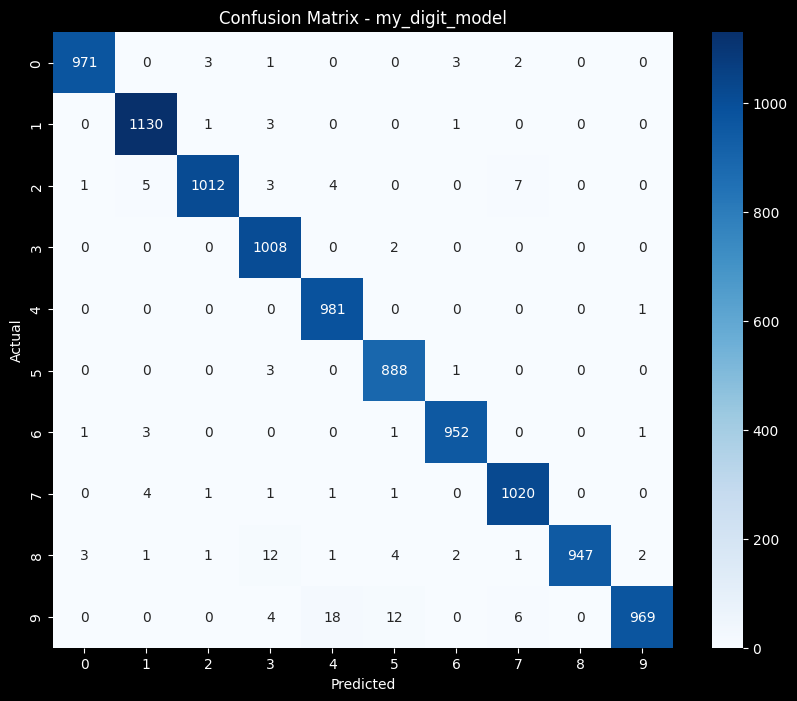


[성능 평가 보고서]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.98      0.99      1032
           3       0.97      1.00      0.99      1010
           4       0.98      1.00      0.99       982
           5       0.98      1.00      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      0.99      0.99      1028
           8       1.00      0.97      0.99       974
           9       1.00      0.96      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [16]:
import os
import cv2
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def train_custom_model():
    # 1. 데이터 로드 및 전처리 (파일 1, 2의 Scaler 원리 적용)
    base_path = "dataset"
    user_images = []
    user_labels = []

    if os.path.exists(base_path):
        print("사용자 데이터를 불러오는중...")
        for digit in range(10):
            dir_path = os.path.join(base_path, str(digit))
            if not os.path.exists(dir_path): continue

            for img_name in os.listdir(dir_path):
                print("img_name is ", img_name)
                img_path = os.path.join(dir_path, img_name)

                # 이미지가 28*28 흑백으로 저장되어 있다고 가정
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img = cv2.resize(img, (28, 28)) # 크기 동일
                    user_images.append(img)
                    user_labels.append(digit)
        print(f"사용자 데이터 {len(user_images)}개 로드 완료")

    # MNIST 데이터 로드
    (x_mnist, y_mnist), (x_test, y_test) = keras.datasets.mnist.load_data()

    # 3. 데이터 합치기 (사용자 데이터가 있을 경우)
    if len(user_images) > 0:# 사용자 데이터를 10배 복제 (약 1만 장 효과)
        # 똑같은 사진이라도 여러 번 보여주면, 모델은 해당 이미지를 틀렸을 때 발생하는 손실(Loss)을 더 크게 느낀다.
        # 즉, "이 필체는 중요하니까 절대 틀리면 안 된다"라고 강제로 주입한다
        user_x_boosted = np.repeat(np.array(user_images), 10, axis=0)
        user_y_boosted = np.repeat(np.array(user_labels), 10, axis=0)
        x_all = np.concatenate((x_mnist, user_x_boosted), axis=0)
        y_all = np.concatenate((y_mnist, user_y_boosted), axis=0)
        # x_all = np.concatenate((x_mnist, np.array(user_images)), axis=0)
        # y_all = np.concatenate((y_mnist, np.array(user_labels)), axis=0)
    else:
        x_all, y_all = x_mnist, y_mnist

    # 2. Scaler 적용 (Essential)
    # 이미지 데이터는 0~255 사이이므로 255로 나누어 0~1 사이로 정규화 한다.
    x_all = x_all.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0

    # CNN 입력을 위한 차원 변경 (샘플수, 가로, 세로, 채널)
    x_all = x_all.reshape(-1, 28, 28, 1)
    x_test = x_test.reshape(-1, 28, 28, 1)

    # 3. K-Fold 교차 검증 및 최적화 (파일 5 기술)
    # 사용자 데이터가 37개로 적기 때문에 5-Fold 까지 안해도 된다
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    fold_no = 1

    # 데이터 증강 (상상력 키워주기)
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        fill_mode='constant',
        cval=0
    )

    for train_index, val_index in skf.split(x_all, y_all):
        print(f'--- Training Fold {fold_no} ---')
        train_x, val_x = x_all[train_index], x_all[val_index]
        train_y, val_y = y_all[train_index], y_all[val_index]

        # 4. 모델 설계 (파일 6, 7의 신경망 구조)
        model = keras.Sequential([
            layers.Input(shape=(28, 28, 1)),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.5), # 과적합 방지 (파일 6)
            layers.Dense(10, activation='softmax')
        ])

        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        model.fit(
            datagen.flow(train_x, train_y, batch_size=32),
            epochs=5,
            validation_data=(val_x, val_y),
            verbose=1
        )

        fold_no += 1
        if fold_no > 2: break # 시간 관계상 2-Fold 까지만 진행


    # 6. 모델 저장
    model.save("my_digit_model.keras")
    print("모델 저장 완료: my_digit_model.keras")

    # 7. 성능 평가 (파일 5 기술: Confusion Matrix, Precision, Recall)
    y_pred = np.argmax(model.predict(x_test), axis=1)

    # 오차 행렬 시각화
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix - my_digit_model')
    plt.show()

    # 정밀도, 재현율 출력
    print("\n[성능 평가 보고서]")
    print(classification_report(y_test, y_pred))

    return model

# 학습 실행
trained_model = train_custom_model()

In [18]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def build_model():
    model = keras.Sequential([
        layers.Input(shape=(28, 28, 1)),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    return model

# 1. 데이터 준비
(x_mnist, y_mnist), (x_test, y_test) = keras.datasets.mnist.load_data()
x_mnist = x_mnist.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

# 사용자 데이터 로드 및 오버샘플링
user_images = []
user_labels = []
base_path = "dataset"

for digit in range(10):
    dir_path = os.path.join(base_path, str(digit))
    if not os.path.exists(dir_path): continue
    for img_name in os.listdir(dir_path):
        img = cv2.imread(os.path.join(dir_path, img_name), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (28, 28))
            user_images.append(img)
            user_labels.append(digit)

user_x = np.array(user_images).reshape(-1, 28, 28, 1).astype('float32') / 255.0
user_y = np.array(user_labels)

# 전략 1: 오버샘플링 (사용자 데이터를 100배 복제)
user_x_oversampled = np.repeat(user_x, 100, axis=0)
user_y_oversampled = np.repeat(user_y, 100, axis=0)

# 2. [Phase 1] MNIST 기초 학습
print("--- Phase 1: MNIST Pre-training ---")
model = build_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_mnist, y_mnist, epochs=3, batch_size=128, validation_split=0.1)

# 3. [Phase 2] 파인 튜닝 (Fine-tuning)
print("--- Phase 2: Fine-tuning with User Data ---")

# 전략 2: 강력한 데이터 증강 설정
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.2,
    shear_range=0.15,
    fill_mode='constant',
    cval=0
)

# 전략 3: 학습률(Learning Rate)을 낮게 설정하여 미세 조정
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5), # 매우 낮은 학습률
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 사용자 데이터와 MNIST 일부를 섞어서 학습 (Catastrophic Forgetting 방지)
# MNIST 2000개 정도만 샘플링해서 사용자 데이터와 혼합
indices = np.random.choice(len(x_mnist), 2000, replace=False)
mixed_x = np.concatenate((user_x_oversampled, x_mnist[indices]), axis=0)
mixed_y = np.concatenate((user_y_oversampled, y_mnist[indices]), axis=0)

model.fit(
    datagen.flow(mixed_x, mixed_y, batch_size=32),
    epochs=10,
    validation_data=(x_test, y_test)
)

model.save("finetuned_digit_model.keras")

--- Phase 1: MNIST Pre-training ---
Epoch 1/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - accuracy: 0.9424 - loss: 0.2021 - val_accuracy: 0.9423 - val_loss: 0.1759
Epoch 2/3
412/422 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9797 - loss: 0.0681

KeyboardInterrupt: 

# 이미지 전처리 코드


In [11]:
import cv2
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# OpenCV 전처리 함수
def preprocess_digit(roi_img, debug=False):
    # 1. ROI 의 가장자리 5픽셀을 잘라내기 (Border 제거)
    # 너무 많이 잘라낼 경우 경계면에 안 닿은 일반 숫자도 제거해버려서 적당히 5픽셀 정도만 제거
    offset = 5
    roi_clean = roi_img[offset:-offset, offset:-offset]

    # 2. 그레이스케일 변환 및 대비 향상 -> 이진화 위해
    gray_image = cv2.cvtColor(roi_clean, cv2.COLOR_BGR2GRAY)

    # 이미지 반전 (핸드폰 이미지 캡쳐시 반대로 나옴)
    gray_image = np.flip(gray_image, 1)

    # 빛 반사 줄이기 위해 clahe 사용
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced_gray = clahe.apply(gray_image)

    # 잡음 제거
    blur = cv2.medianBlur(gray_image, 5)
    # blur = cv2.GaussianBlur(enhanced_gray, (5, 5), 3)
    # blur = cv2.bilateralFilter(gray_image, 9, 75, 75) # 9: 필터 크기, 75: 색 공간 표준편차, 75: 좌표 공간 표준편차

    # 핵심: 적응형 이진화(adaptive thresholding)
    # 얇은 글자를 선명하게 살려냄
    # INV 를 써서 처음부터 배경을 검정색으로 만들기 -> bitwise 대신
    binary = cv2.adaptiveThreshold(blur,
                                       255,
                                       cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY_INV, 21, 5) # C 값을 7에서 5로 낮춰 더 민감하게 잡음

    kernel = np.ones((5, 5), np.uint8)

    # 팽창을 너무 과하게 하면 빛(잡음)까지 커져서 숫자로 인식함
    # 하지만 침식을 너무 많이 하면 글자가 끊겨보임 -> 적절하게 조절 필요
    # closed_img = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    # processed_img = cv2.dilate(closed_img, kernel, iterations=2)

    # 팽창 후 침식 3번
    processed_img = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2) # 다시 한번 깎기

    if (debug == True):
        cv2.imshow("gray_image", gray_image)
        cv2.imshow("clahe", enhanced_gray)
        cv2.imshow("blur", blur)
        cv2.imshow("binary1", binary)

    return processed_img

In [13]:
def extract_digits(processed_img, num_digits=4, debug=False):
    """
    이진화된 이미지에서 숫자 영역을 찾아내어 28*28 이미지 리스트로 반환
    """
    # 1. 외곽선 찾기
    # RETR_LIST 사용시 6 검출할 때 0 도 같이 검출됨
    contours, _ = cv2.findContours(processed_img.copy(),
                                   cv2.RETR_EXTERNAL,
                                   cv2.CHAIN_APPROX_SIMPLE
                                   )

    # 디버그 모드 시 시각화용 복사본 생성 (원본 보존)
    if debug:
        contour_view = cv2.cvtColor(processed_img, cv2.COLOR_GRAY2BGR)
        # 검출된 모든 외곽선을 초록색으로 그램
        cv2.drawContours(contour_view, contours, -1, (0, 255, 0), 2)

    roi_h, roi_w = processed_img.shape
    roi_area = roi_h * roi_w
    digit_rects = []

    # 2. 숫자 후보 필터링
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = cv2.contourArea(cnt)
        print("x, y, w, h : ", x, y, w, h)
        print("area : ", area)

        # 너무 큰 덩어리 제외 (테두리 등)
        if area > (roi_area * 0.95): continue
        # 너무 작은 잡음 제외
        if area < 500: continue
        # 경계면에 닿은 덩어리 제외 (마진 설정)
        margin = 5 # 너무 크게 주면 숫자도 인식 안함
        # 종횡비 체크 (가로로 긴 것은 제외)
        aspect_ratio = w / float(h)
        if aspect_ratio > 3.0:
            continue

        # 경계면에 닿아있는가?
        is_margin = x < margin or y < margin or (x+w) > (roi_w - margin) or (y+h)  > (roi_h-margin)
        if is_margin: continue

        digit_rects.append((x, y, w, h))

    # 3. 면적 순으로 정렬 후 상위 4개 선택 (비밀번호 4자리 기준)
    digit_rects = sorted(digit_rects, key=lambda r: r[2]*r[3], reverse=True)[:num_digits]

    # 4. 왼쪽에서 오른쪽 순서로 다시 정렬 (비밀번호 순서)
    digit_rects.sort(key=lambda r: r[0])

    digit_images = []
    padding = 15

    # 5. 각 영역 크롭 및 리사이즈
    for i, (x, y, w, h) in enumerate(digit_rects):
        if debug:
            cv2.rectangle(contour_view, (x, y), (x+w, y+h), (0, 0, 255), 2)
            cv2.putText(contour_view, str(i), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
        x1, y1 = max(0, x-padding), max(0, y-padding)
        x2, y2 = min(roi_w, x+w+padding), min(roi_h, y+h+padding)

        # 슬라이싱
        digit_crop = processed_img[y1:y2, x1:x2]

        # 28 * 28 로 리사이즈
        resized_img = cv2.resize(digit_crop, (28, 28), interpolation=cv2.INTER_AREA)
        digit_images.append(resized_img)

        if debug:
            cv2.rectangle(contour_view, (x, y), (x+w, y+h), (0, 0, 255), 2)
            cv2.imshow(f"Debug_Crop_{i}", resized_img)

    if debug:
        cv2.imshow("Debug_Contours_and_Boxes", contour_view)
    return digit_images, digit_rects

# 사용자 글씨 캡쳐

In [10]:
import cv2
import numpy as np
import random
from scipy.ndimage import gaussian_filter

def apply_elastic_transform(image, alpha=35, sigma=4):
    """이미지를 젤리처럼 뒤트는 탄성 변형 적용"""
    random_state = np.random.RandomState(None)
    shape = image.shape

    # 무작위 변위 필드 생성 (가우시안 필터로 부드럽게 만듦)
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha

    # 픽셀 좌표 맵 생성
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    map_x = (x + dx).astype('float32')
    map_y = (y + dy).astype('float32')

    return cv2.remap(image, map_x, map_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)

def augment_image_opencv(img, count=10, debug=False):
    aug_images = []
    h, w = img.shape[:2]

    for i in range(count):
        # --- [1] 탄성 변형 (Elastic Transform) ---
        # 70% 확률로 적용하여 원본 형태도 유지
        transformed = img.copy()
        if random.random() > 0.3:
            transformed = apply_elastic_transform(transformed, alpha=random.uniform(25, 35), sigma=random.uniform(3, 4))
            cv2.imshow("transformed", transformed)

        # --- [2] 투영 변환 (Perspective) ---
        margin = 3
        src_pts = np.float32([[0, 0], [w, 0], [0, h], [w, h]])
        dst_pts = np.float32([
            [random.uniform(0, margin), random.uniform(0, margin)],
            [w - random.uniform(0, margin), random.uniform(0, margin)],
            [random.uniform(0, margin), h - random.uniform(0, margin)],
            [w - random.uniform(0, margin), h - random.uniform(0, margin)]
        ])
        M_persp = cv2.getPerspectiveTransform(src_pts, dst_pts)
        transformed = cv2.warpPerspective(transformed, M_persp, (w, h), borderValue=0)
        cv2.imshow("warpPerspective", transformed)

        # --- [3] 아핀 변환: 기울기(Shearing) 및 크기(Scaling) ---
        # Shear: 글씨가 옆으로 누운 정도 조절
        shear_factor = random.uniform(-0.15, 0.15)
        M_shear = np.float32([[1, shear_factor, 0], [0, 1, 0]])
        transformed = cv2.warpAffine(transformed, M_shear, (w, h), borderValue=0)
        cv2.imshow("warpAffine1", transformed)

        # Scale: 크기를 90%~110% 사이로 조절
        scale = random.uniform(0.9, 1.1)
        M_scale = cv2.getRotationMatrix2D((w/2, h/2), 0, scale)
        transformed = cv2.warpAffine(transformed, M_scale, (w, h), borderValue=0)
        cv2.imshow("warpAffine2", transformed)

        # --- [4] 무작위 회전 및 이동 ---
        angle = random.uniform(-15, 15)
        tx = random.uniform(-2, 2)
        ty = random.uniform(-2, 2)
        M_rot = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
        M_rot[0, 2] += tx
        M_rot[1, 2] += ty
        transformed = cv2.warpAffine(transformed, M_rot, (w, h), borderValue=0)
        cv2.imshow("warpAffine3", transformed)

        # --- [5] 선명하게 (Sharpening) ---
        if random.random() > 0.5:
            kernel_sharp = np.array([[-1,-1,-1], [-1, 9,-1], [-1,-1,-1]])
            transformed = cv2.filter2D(transformed, -1, kernel_sharp)
            cv2.imshow("kernel_sharp", transformed)

        # --- [6] 두께 변화 (Dilation/Erosion) 수정 ---
        # 침식(erode) 확률을 낮추고, 커널 크기를 2x2로 최소화함
        # random.choices의 weights를 통해 각 연산의 발생 빈도를 조절
        option = ['dilate', 'erode', 'none']
        weights = [0.4, 0.1, 0.5]  # 침식(erode)은 10% 확률로만 발생하게 설정
        choice = random.choices(option, weights=weights)[0]

        if choice != 'none':
            # 28x28 이미지에서는 2x2 커널이 마지노선임
            kernel_morph = np.ones((2, 2), np.uint8)
            if choice == 'dilate':
                transformed = cv2.dilate(transformed, kernel_morph, iterations=1)
            elif choice == 'erode':
                # 침식 적용 전, 이미지가 너무 깨지지 않도록 한 번 더 확인하거나
                # 아주 얇은 획을 가진 숫자라면 이 단계를 건너뛰는 것이 좋음
                transformed = cv2.erode(transformed, kernel_morph, iterations=1)
        cv2.imshow("dilate or erode", transformed)
        aug_images.append(transformed)

    return aug_images

In [15]:
import cv2
import numpy as np
import os
from datetime import datetime

# 사용자 글씨 캡쳐
# 이진화 해서 글자 저장
def capture_user_dataset():
    cap = cv2.VideoCapture(0)
    base_path = "dataset"

    # 0~9까지 폴더 생성
    for i in range(10):
        os.makedirs(f"{base_path}/{i}", exist_ok=True)

    print("수집 시작: 숫자 키 (0~9)를 누르면 저장, 'esc'종료")

    while True:
        ret, frame = cap.read()
        if not ret: break
        frame = cv2.flip(frame, 1)
        h, w, _ = frame.shape

        # ROI 영역 표시 (중앙 300*300)
        size = 300
        x1, y1 = (w-size)//2, (h-size)//2
        roi = frame[y1:y1+size, x1:x1+size]

        cv2.rectangle(frame, (x1, y1), (x1+size, y1+size), (0, 255, 0), 2)
        cv2.imshow("Capture (Press 0-9 to Save)", frame)

        key = cv2.waitKey(1) & 0xFF
        if ord('0') <= key <= ord('9'):
            digit = chr(key)
            print("digit : ", digit)

            # 1. 전처리 수행 (이진화 등)
            processed = preprocess_digit(roi)

            # 2. 숫자 추출
            # 수집 시에는 숫자를 하나씩 쓴다고 가정하고,가장 적절한 하나만 저장하거나 추출한다
            digit_images, rects = extract_digits(processed, num_digits=1, debug=True)

            if digit_images:
                # 데이터 수집용이므로 가장 확실한 첫 번째 이미지만 저장
                d_img = digit_images[0]

                augmented_list = augment_image_opencv(d_img, count=30)

                for idx, aug_img in enumerate(augmented_list):
                    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S_%f")
                    filename = f"{digit}_{timestamp}_{idx}.png"
                    img_path = os.path.join(base_path, digit, filename)

                    cv2.imwrite(img_path, aug_img)
                print(f"[{digit}] 저장됨: {len(augmented_list)}개")
                cv2.imshow("Saved Digit", d_img)
            else:
                print("숫자가 검출되지 않았습니다. 여백이나 크기를 조절해 보세요.")

        elif key == 27:
            break

    cap.release()
    cv2.destroyAllWindows()

capture_user_dataset()

수집 시작: 숫자 키 (0~9)를 누르면 저장, 'esc'종료
digit :  1
x, y, w, h :  126 62 52 160
area :  619.5
[1] 저장됨: 30개
digit :  1
x, y, w, h :  0 283 7 2
area :  5.5
x, y, w, h :  32 282 5 1
area :  0.0
x, y, w, h :  12 282 3 1
area :  0.0
x, y, w, h :  149 194 16 4
area :  22.0
x, y, w, h :  123 192 8 3
area :  1.0
x, y, w, h :  145 111 5 76
area :  151.0
x, y, w, h :  147 91 3 11
area :  20.0
숫자가 검출되지 않았습니다. 여백이나 크기를 조절해 보세요.
digit :  1
x, y, w, h :  138 77 66 139
area :  940.0
[1] 저장됨: 30개
digit :  1
x, y, w, h :  158 93 8 105
area :  513.5
[1] 저장됨: 30개
digit :  2
x, y, w, h :  102 93 119 129
area :  1211.5
[2] 저장됨: 30개
digit :  2
x, y, w, h :  113 113 82 78
area :  842.0
[2] 저장됨: 30개
digit :  2
x, y, w, h :  106 73 77 140
area :  1042.5
[2] 저장됨: 30개
digit :  3
x, y, w, h :  154 38 46 219
area :  1139.5
[3] 저장됨: 30개
digit :  3
x, y, w, h :  96 90 118 127
area :  1435.5
[3] 저장됨: 30개
digit :  3
x, y, w, h :  127 51 87 180
area :  1487.5
[3] 저장됨: 30개
digit :  4
x, y, w, h :  100 71 107 144
area :  3474.

# 모델 비교

In [ ]:
import pandas as pd
def compare_models(model1_path, model2_path, x_test, y_test):
    m1 = keras.models.load_model(model1_path)
    m2 = keras.models.load_model(model2_path)

    # 두 모델의 예측값 계산
    y_pred1 = np.argmax(m1.predict(x_test), axis=1)
    y_pred2 = np.argmax(m2.predict(x_test), axis=1)

    # 1. 정확도(accuracy) 비교
    acc1 = np.mean(y_pred1 == y_test)
    acc2 = np.mean(y_pred2 == y_test)

    print(f"[{model1_path}] Accuracy: {acc1:.4f}")
    print(f"[{model2_path}] Accuracy: {acc2:.4f}")

    # 2. 특정 숫자(예: 8)의 재현율(Recall) 비교 - 내 필기체 취약점 확인
    report1 = classification_report(y_test, y_pred1, output_dict=True)
    report2 = classification_report(y_test, y_pred2, output_dict=True)

    print(f"\n[8번 숫자 Recall 비교]")
    print(f"Model 1: {report1['8']['recall']:.4f}")
    print(f"Model 2: {report2['8']['recall']:.4f}")

compare_models("my_digit_model.keras", "advanced_digit_cnn.keras", x_test, y_test)

In [ ]:
# 메인 관련 로직

In [ ]:
def compare_faces(face_img1, face_img2):
    # 이미지를 일정한 크기로 리사이즈
    img1 = cv2.resize(face_img1, (100, 100))
    img2 = cv2.resize(face_img2, (100, 100))

    # 히스토그램 계산 (색상 분포 분석)
    hist1 = cv2.calcHist([img1], [0], None, [256], [0, 256])
    hist2 = cv2.calcHist([img2], [0], None, [256], [0, 256])

    # 유사도 측정 (1.0에 가까울수록 동일 인물)
    similarity = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)
    print("similarity : ", similarity)
    return similarity

In [21]:
import json

# 비밀번호 파일 경로
PW_FILE = "lock_config.json"

def load_password():
    """파일에서 비밀번호 읽어오기. 파일이 없으면 기본값 설정"""
    if os.path.exists(PW_FILE):
        with open(PW_FILE, 'r') as f:
            data = json.load(f)
            return data.get("password", [1, 2, 3, 4])
    else:
        # 초기 파일 생성
        save_password([1, 2, 3, 4])
        return [1, 2, 3, 4]

def save_password(new_pw):
    """새로운 비밀번호를 파일에 저장."""
    with open(PW_FILE, 'w') as f:
        json.dump({"password": new_pw}, f)
        print(f"비밀번호가 {new_pw}로 저장되었습니다.")

password = load_password()

In [ ]:
# OpenCV 한테 숫자 줌 -> 그게 패스워드가됨 -> 그 패스워드가 맞는지 아닌지?
# import cv2 as cv
import cv2
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# model = keras.models.load_model("advanced_digit_cnn.keras")
model = keras.models.load_model("my_digit_model.keras")

print(model.summary())

password = [5, 6, 7, 8]
input_digits = []
status_message = "Capture 4 digits (Press 'C')"

cap = cv2.VideoCapture(0)
# 해상도 높이기
# cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
# cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
if not cap.isOpened():
    print("웹캡을 열 수 없습니다")
    exit()

while True:
    ret, frame = cap.read() # ret은 true와 false를 담음
    if not ret:
        print("프레임을 가져올 수 없습니다")
        break

    flip_frame = cv2.flip(frame, 1)
    height, width, _ = frame.shape # _는 color가 넘어옴
    center_x, center_y = width // 2, height // 2 # 프레임의 가운데가 찍힘

    # ROI 설정 (300*300)
    roi_size = 300
    roi_half = roi_size // 2
    roi = flip_frame[center_y - roi_half:center_y + roi_half, center_x - roi_half:center_x + roi_half]

    cv2.rectangle(flip_frame,
                  (center_x - roi_half, center_y - roi_half),
                  (center_x + roi_half, center_y + roi_half),
                  (0, 0, 255),
                  2)

    cv2.putText(flip_frame, f"Input: {input_digits}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)
    cv2.putText(flip_frame, status_message, (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 0), 2)

    cv2.imshow("Webcam", flip_frame)

    # 화면 캡처를 위한 키 값 받기
    key = cv2.waitKey(1) & 0xFF

    if key == ord('c') or key == ord('C'):
        # 흑백이어야 하는 이유
        # AI 입장에서는 어디가 바탕이고, 어디가 글씨인가만 알면 된다
        # 색상 정보가 섞여있으면 AI는 이건 빨간색이라 3인가? 파란색이라 8인가? 라고 헷갈려 할 수 있다.
        # 그래서 색을 다 빼버리고(grayScale) 더 나아가 바탕은 검정, 글씨는 하양(이진화)로 극명하게 대비를 시켜주는 것이다
        # 1. 전처리 시작 (회색조 -> 블러)
        processed_img = preprocess_digit(roi)
        cv2.imshow("Debug_Processed", processed_img)

        # 2. 이미지 컨투어링
        digit_images, rects = extract_digits(processed_img, debug=True)
        print("digit_images : ", digit_images)
        print("rects : ", rects)
        detected_numbers = []

        for i, img in enumerate(digit_images):
            # 정규화 및 차원 확장
            input_data = (img / 255.0).reshape(1, 28, 28, 1) # CNN 입력 규격

            prediction = model.predict(input_data, verbose=0)
            digit = np.argmax(prediction)
            detected_numbers.append(int(digit))
            cv2.imshow(f"Final_To_AI_{i}", img) # AI에게 들어가는 최종 모습 확인

            print(f"인식된 개별 숫자: {digit}, 확률: {prediction[0][digit]*100:.2f}%")

        print(f"최종 인식된 숫자들: {detected_numbers}")

        for d in detected_numbers:
            if len(input_digits) < 4:
                input_digits.append(d)

        if len(input_digits) == 4:
            # 맞으면 성공, 틀리면 실패 메시지를 띄운다
            if input_digits == password:
                status_message = "SUCCESS! Welcome!"
            else:
                status_message = "WRONG PASSWORD! Resetting..."

            print(f"Final Input: {input_digits}, Result: {status_message}")
            input_digits = []
            password = []

    elif key == ord('s') or key == ord('S'):
        status_message = "SETTING MODE: Capture 4 new digits"
        save_password(detected_numbers)
        password = detected_numbers
        status_message = "Password Changed Successfully!"
    elif key == 27:
        break

cap.release()
cv2.destroyAllWindows()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       803,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,501,888 (9.54 MB)

 Trainable params: 833,898 (3.18 MB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 1,667,798 (6.36 MB)

None
x, y, w, h :  132 55 94 169
area :  1267.0
digit_images :  [array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,  99,  73,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   4,   0,
          0,   0],
       [  0,   0,   0,   0,   0, 148,  82,   0,   0,   0,   0,   0,   0,
          0,   0,   6,  26,  57,  88, 114, 124, 119, 112, 117,  67,   0,
          0,   0],
       [  0,   0,   0,   0,   0, 185,  82,   0,   0,  37,  77, 103, 116,
        116, 116, 109,  90,  56,  39,   9,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0, 206, 179, 140, 116,  95,  39,   5,   0,
          0,   0,   0,   0,   0,   0,